In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False # 解决保存图像是负号'-'显示为方块的问题
user_info=pd.read_csv('user_info.csv')
type_dict={'排序算法':0,'查找算法':1,'图结构':2,'树结构':3,'数字操作':4,'字符串':5,'线性表':6,'数组':7}


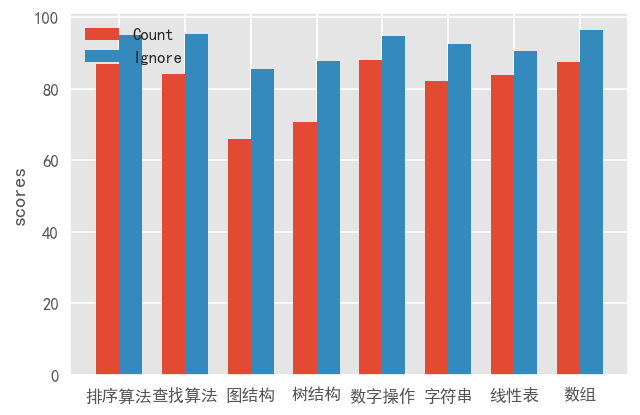

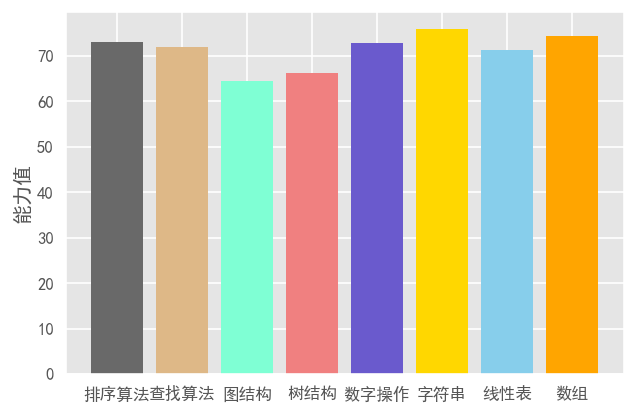

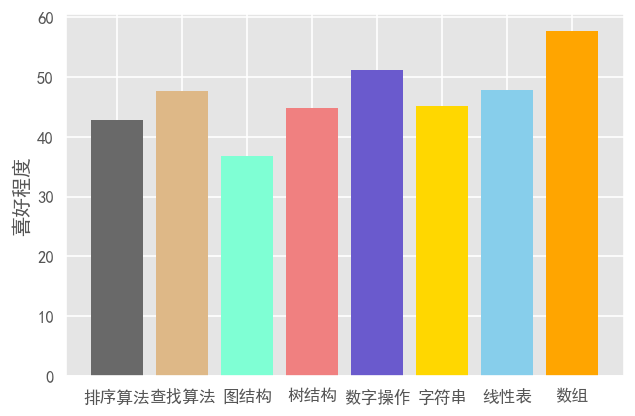

In [35]:
labels = list(type_dict.keys())
color=['dimgray','burlywood','aquamarine','lightcoral','slateblue','gold','skyblue','orange']
x = np.arange(len(labels))
width = 0.35
def scorebar():
    xc=[np.mean(user_info['avgScoreOfType0'].values),np.mean(user_info['avgScoreOfType1'].values),np.mean(user_info['avgScoreOfType2'].values),
        np.mean(user_info['avgScoreOfType3'].values),np.mean(user_info['avgScoreOfType4'].values),np.mean(user_info['avgScoreOfType5'].values),
        np.mean(user_info['avgScoreOfType6'].values),np.mean(user_info['avgScoreOfType7'].values)]
    xi=[np.mean(user_info['avgScoreIgnoreUndoOfType0'].values),np.mean(user_info['avgScoreIgnoreUndoOfType1'].values),
        np.mean(user_info['avgScoreIgnoreUndoOfType2'].values),
        np.mean(user_info['avgScoreIgnoreUndoOfType3'].values),np.mean(user_info['avgScoreIgnoreUndoOfType4'].values),
        np.mean(user_info['avgScoreIgnoreUndoOfType5'].values),
        np.mean(user_info['avgScoreIgnoreUndoOfType6'].values),np.mean(user_info['avgScoreIgnoreUndoOfType7'].values)]
    fig,ax=plt.subplots(1,1,figsize=(6,4),dpi=120)
    plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
    plt.rcParams['axes.unicode_minus']=False # 解决保存图像是负号'-'显示为方块的问题
    rect1 = ax.bar(x - width / 2, xc, width, label='Count')
    rect2 = ax.bar(x + width / 2, xi, width, label='Ignore')
    ax.set_ylabel('scores')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.legend([rect1, rect2], ['Count', 'Ignore'], loc='upper left')
def abilitybar():
    xc=[np.mean(user_info['userAbilityOfType0'].values),np.mean(user_info['userAbilityOfType1'].values),np.mean(user_info['userAbilityOfType2'].values),
        np.mean(user_info['userAbilityOfType3'].values),np.mean(user_info['userAbilityOfType4'].values),np.mean(user_info['userAbilityOfType5'].values),
        np.mean(user_info['userAbilityOfType6'].values),np.mean(user_info['userAbilityOfType7'].values)]
    fig,ax=plt.subplots(1,1,figsize=(6,4),dpi=120)
    plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
    plt.rcParams['axes.unicode_minus']=False # 解决保存图像是负号'-'显示为方块的问题
    ax.bar(x, xc, color=color)
    ax.set_ylabel('能力值')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
def likebar():
    xc=[np.mean(user_info['likeDegreeOfType0'].values),np.mean(user_info['likeDegreeOfType1'].values),np.mean(user_info['likeDegreeOfType2'].values),
        np.mean(user_info['likeDegreeOfType3'].values),np.mean(user_info['likeDegreeOfType4'].values),np.mean(user_info['likeDegreeOfType5'].values),
        np.mean(user_info['likeDegreeOfType6'].values),np.mean(user_info['likeDegreeOfType7'].values)]
    fig,ax=plt.subplots(1,1,figsize=(6,4),dpi=120)
    plt.style.use('ggplot')
    plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
    plt.rcParams['axes.unicode_minus']=False # 解决保存图像是负号'-'显示为方块的问题
    ax.bar(x, xc,color=color)
    ax.set_ylabel('喜好程度')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
scorebar()
abilitybar()
likebar()

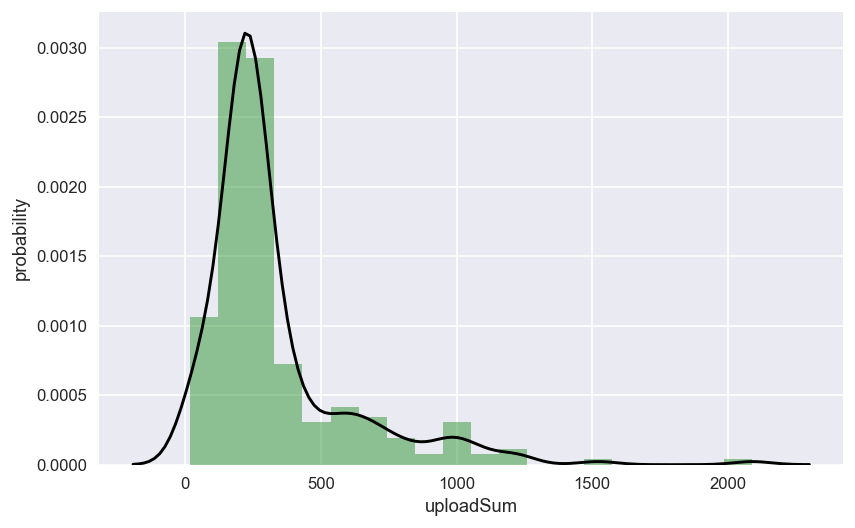

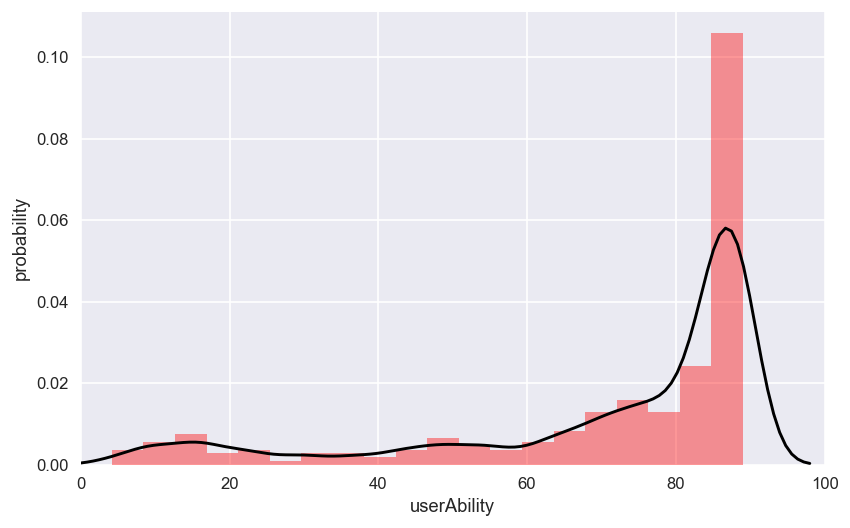

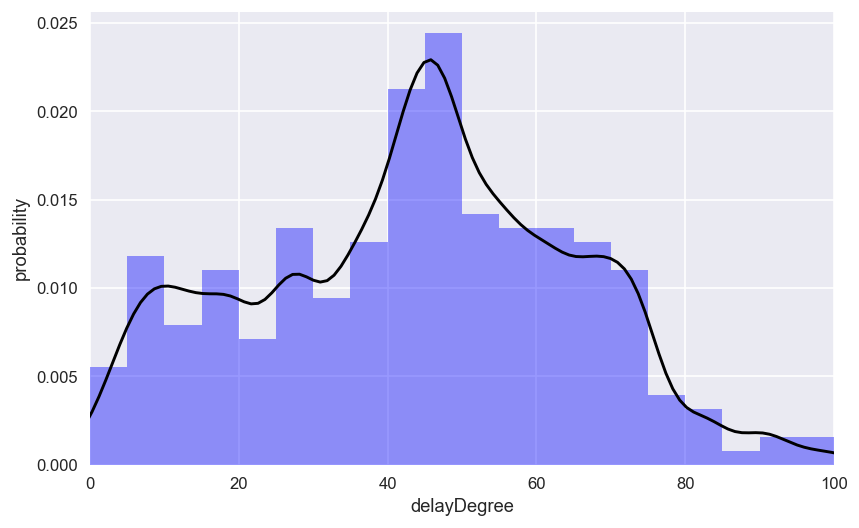

In [21]:
def getUploadhist():
    plt.style.use('seaborn')
    data=user_info['uploadSum']
    fig,ax=plt.subplots(figsize=(8,5),dpi=120)
    ax.set_xlabel('uploadSum')
    ax.set_ylabel('probability')
    sns.distplot(data,bins=20,color="g",
                 kde_kws={"color": "k", "bw": 70})
def getAbilityhist():
    plt.style.use('seaborn')
    data=user_info['userAbility']
    fig,ax=plt.subplots(figsize=(8,5),dpi=120)
    ax.set_xlim((0,100))
    ax.set_xlabel('userAbility')
    ax.set_ylabel('probability')
    sns.distplot(data,bins=20,color="r",
                 kde_kws={"color": "k", "bw": 3})
def getDelayhist():
    plt.style.use('seaborn')
    data=user_info['delayDegree']
    fig,ax=plt.subplots(figsize=(8,5),dpi=120)
    ax.set_xlim((0,100))
    ax.set_xlabel('delayDegree')
    ax.set_ylabel('probability')
    sns.distplot(data,bins=20,color="b",
                 kde_kws={"color": "k", "bw": 3})
getUploadhist()
getAbilityhist()
getDelayhist()

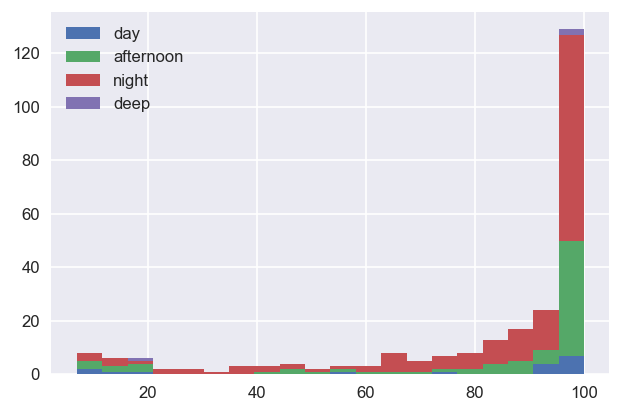

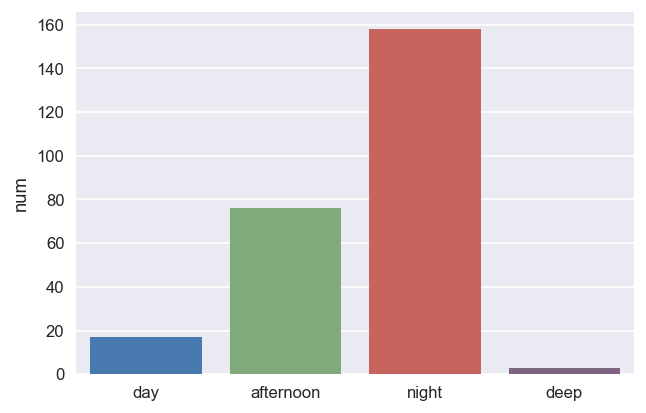

In [36]:
def getTimeTypeandScoreView():
    plt.style.use('seaborn')
    day_stu=user_info[user_info['timeType']==0]['avgScore'].values
    aft_stu=user_info[user_info['timeType']==1]['avgScore'].values
    night_stu=user_info[user_info['timeType']==2]['avgScore'].values
    deep_stu=user_info[user_info['timeType']==3]['avgScore'].values
    y=[day_stu.shape[0],aft_stu.shape[0],night_stu.shape[0],deep_stu.shape[0]]
    stu=np.array([day_stu,aft_stu,night_stu,deep_stu])
    data=pd.DataFrame({'timeType':user_info['timeType'],'score':user_info['avgScore'],'score_i':user_info['avgScoreIgnoreUndo']})
    data=data.corr(method='kendall')
    labels=['day','afternoon','night','deep']
    fig,ax=plt.subplots(1,1,figsize=(6,4),dpi=120)
    ax.hist(stu, 20,  histtype='bar', stacked=True,label=labels)
    ax.legend(loc='upper left')
    plt.show()
    fig,ax=plt.subplots(1,1,figsize=(6,4),dpi=120)
    ax.set_ylabel('num')
    ax.set_ylabel('num')
    sns.barplot(x=labels, y=y, palette=sns.xkcd_palette(["windows blue","faded green","pale red","dusty purple"]))
    plt.show()
getTimeTypeandScoreView()

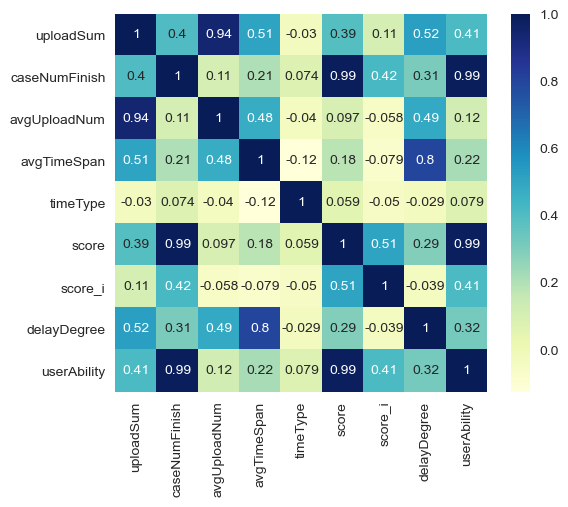

E:\Anaconda\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


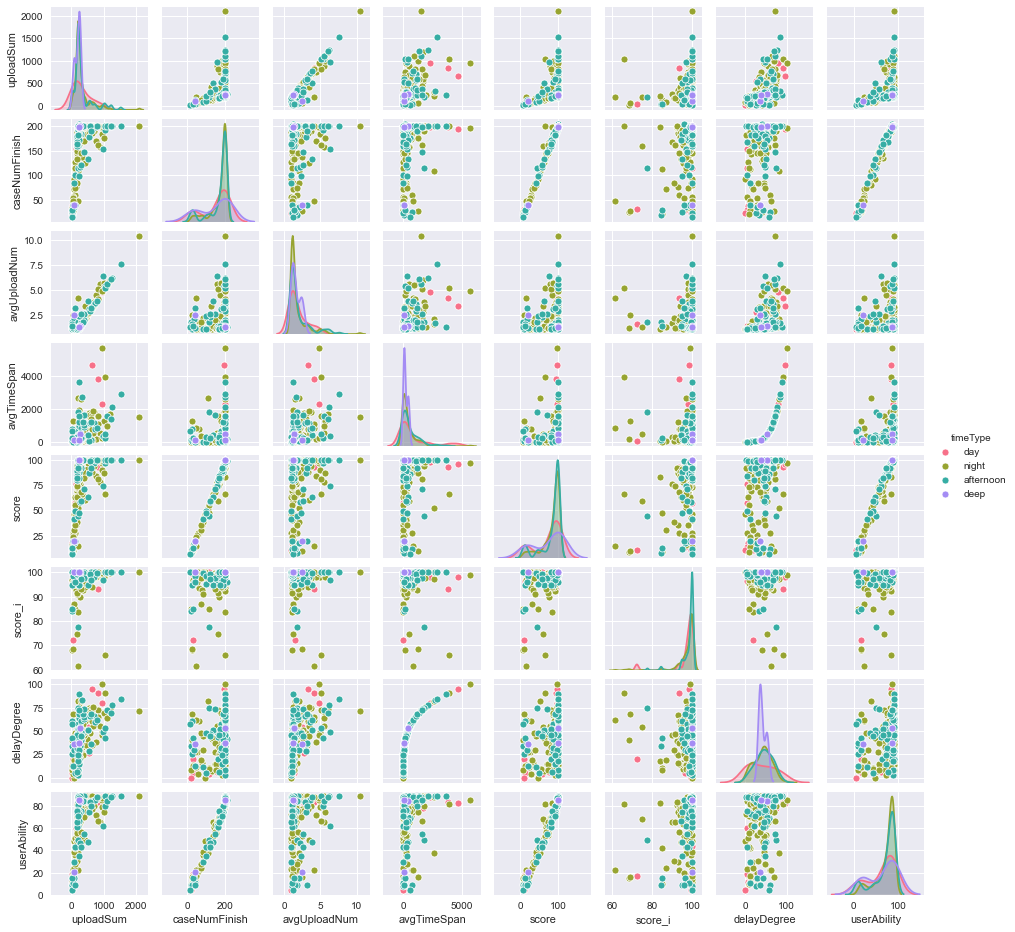

In [20]:
data=pd.DataFrame({'uploadSum':user_info['uploadSum'],'caseNumFinish':user_info['caseNumFinish'],'avgUploadNum':user_info['avgUploadNum'],
                   'avgTimeSpan':user_info['avgTimeSpan'],'timeType':user_info['timeType'],'score':user_info['avgScore'],
                   'score_i':user_info['avgScoreIgnoreUndo'],'delayDegree':user_info['delayDegree'],'userAbility':user_info['userAbility']})
cor=data.corr()
fig=plt.figure(figsize=(6,5),dpi=100)
ax=plt.subplot(111)
sns.heatmap(cor,annot=True,cmap='YlGnBu')
plt.show()
timeType=[]
for i in data['timeType']:
    if i==0:
        timeType.append('day')
    elif i==1:
        timeType.append('afternoon')
    elif i==2:
        timeType.append('night')
    else:
        timeType.append('deep')
data['timeType']=timeType
sns.pairplot(data, hue="timeType",palette="husl",height=1.6)
plt.show()

In [4]:
# cases_analysis_result=pd.read_csv('E:\\0学习资料\\A软件工程\\数据科学大作业\\data-science\\cases_analysis_final.csv')
# data=pd.DataFrame({'finish_rate':cases_analysis_result['finishRate'],'average_point_i':cases_analysis_result['scoreIgnoreUndo'],
#                    'average_point':cases_analysis_result['scoreCountUndo'],'upload_num':cases_analysis_result['uploadAvg'],
#                   'time_span':cases_analysis_result['timeSpan'],'runtime':cases_analysis_result['avgRunTime'],
#                    'difficulty':cases_analysis_result['difficultDegree']},index=[i for i in range(882)] )


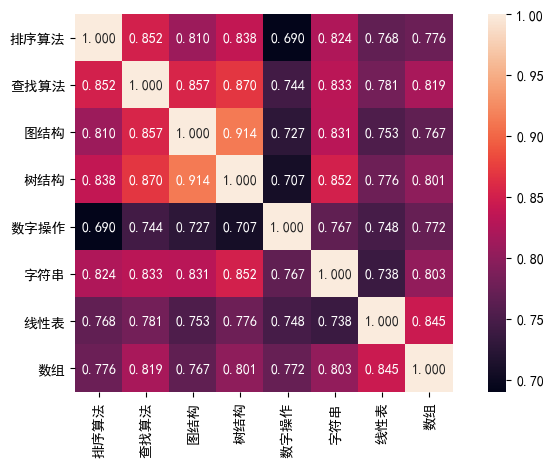

In [12]:
data=pd.DataFrame({'排序算法':user_info['avgScoreOfType0'],'查找算法':user_info['avgScoreOfType1'],'图结构':user_info['avgScoreOfType2'],
        '树结构':user_info['avgScoreOfType3'],'数字操作':user_info['avgScoreOfType4'],'字符串':user_info['avgScoreOfType5'],
        '线性表':user_info['avgScoreOfType6'],'数组':user_info['avgScoreOfType7']})
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
corrmat=data.corr(method='spearman')
plt.figure(figsize=(9,5),dpi=100)
sns.heatmap(corrmat, annot=True, fmt='.3f', square=True);
plt.show()